# 04 – Model Comparison (Baseline vs. BERT)

Ziel: Vergleich eines klassischen ML-Baselines (TF-IDF + Logistic Regression) mit Fine-Tuned BERT auf dem BBC News Dataset.


In [1]:
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().parent
DATA_CSV = PROJECT_ROOT / "data" / "processed" / "bbc_news.csv"

RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(exist_ok=True)

DATA_CSV


WindowsPath('c:/CAS/cas-ml-document-classification/data/processed/bbc_news.csv')

CSV laden, Split definieren (reproduzierbar)

In [2]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(DATA_CSV)

# Label Encoding (stabile Reihenfolge!)
labels_sorted = sorted(df["label"].unique())
label2id = {l:i for i,l in enumerate(labels_sorted)}
id2label = {i:l for l,i in label2id.items()}

y = df["label"].map(label2id).values
X_text = df["text"].astype(str).values

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

len(X_train), len(X_test), labels_sorted


(1780, 445, ['business', 'entertainment', 'politics', 'sport', 'tech'])

Baseline: TF-IDF + Logistic Regression (neu berechnen, damit Notebook standalone ist)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

baseline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2), stop_words="english")),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=-1))
])

baseline.fit(X_train, y_train)
baseline_pred = baseline.predict(X_test)


BERT: Laden (vom gespeicherten Checkpoint)

In [4]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

BERT_DIR = PROJECT_ROOT / "results" / "bert" / "best_model"  # <- ggf. anpassen

tokenizer = AutoTokenizer.from_pretrained(BERT_DIR)
bert_model = AutoModelForSequenceClassification.from_pretrained(BERT_DIR)
bert_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

MAX_LEN = 128  # so wie du trainiert hast (falls 256 genutzt: hier anpassen)

def bert_predict(texts, batch_size=16):
    preds = []
    probs_max = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            list(batch),
            truncation=True,
            padding=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            out = bert_model(**enc)
            prob = torch.softmax(out.logits, dim=1)
            pred = torch.argmax(prob, dim=1)

        preds.extend(pred.cpu().numpy().tolist())
        probs_max.extend(prob.max(dim=1).values.cpu().numpy().tolist())

    return np.array(preds), np.array(probs_max)

bert_pred, bert_conf = bert_predict(X_test, batch_size=16)

bert_pred[:5], bert_conf[:5].round(3)


(array([0, 0, 1, 0, 0]), array([0.991, 0.99 , 0.987, 0.991, 0.992]))

Metriken + Vergleichstabelle

In [5]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "macro_precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "macro_recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
    }

m_baseline = metrics(y_test, baseline_pred)
m_bert = metrics(y_test, bert_pred)

results = pd.DataFrame([
    {"model": "TF-IDF + Logistic Regression", **m_baseline},
    {"model": "BERT (fine-tuned)", **m_bert}
])

results


,model,accuracy,macro_f1,macro_precision,macro_recall
0,TF-IDF + Logistic Regression,0.991011,0.991189,0.990799,0.991737
1,BERT (fine-tuned),0.982022,0.982443,0.981883,0.983053


Dataset stark keyword-trennbar → LogReg extrem gut

BERT liefert trotzdem sehr hohe Performance, aber mehr Compute

Transfer: bei weniger klaren Dokumenten kann BERT robuster sein

Speichern (für Arbeit)

In [6]:
out_path = RESULTS_DIR / "model_comparison_metrics.csv"
results.to_csv(out_path, index=False)
out_path


WindowsPath('c:/CAS/cas-ml-document-classification/results/model_comparison_metrics.csv')

Confusion Matrix für BERT (schön)

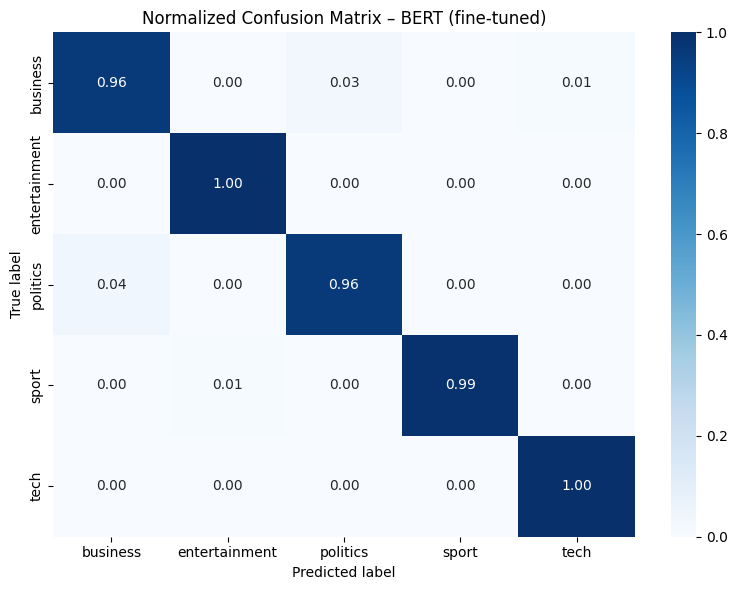

WindowsPath('c:/CAS/cas-ml-document-classification/results/bert_confusion_matrix_normalized.png')

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_test, bert_pred, labels=list(range(len(labels_sorted))))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels_sorted, yticklabels=labels_sorted)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix – BERT (fine-tuned)")
plt.tight_layout()

fig_path = RESULTS_DIR / "bert_confusion_matrix_normalized.png"
plt.savefig(fig_path, dpi=300)
plt.show()

fig_path


Optional: Counts statt Prozent

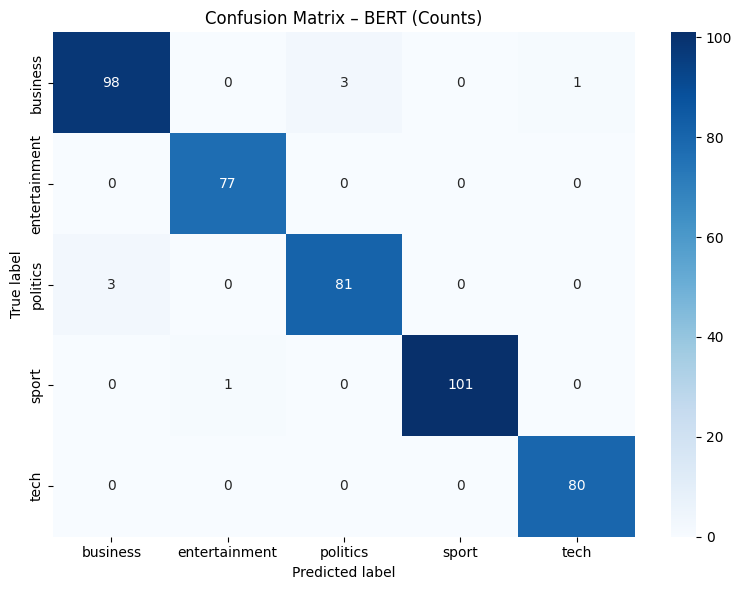

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – BERT (Counts)")
plt.tight_layout()
plt.show()


Kurze Error Analysis (Top 10 falsch klassifizierte Beispiele)

In [9]:
wrong_idx = np.where(bert_pred != y_test)[0]

err = pd.DataFrame({
    "true": [id2label[i] for i in y_test[wrong_idx]],
    "pred": [id2label[i] for i in bert_pred[wrong_idx]],
    "confidence": bert_conf[wrong_idx],
    "text": [X_test[i] for i in wrong_idx]
})

err_sorted = err.sort_values("confidence", ascending=False)
err_sorted.head(10)[["true", "pred", "confidence"]]


,true,pred,confidence
4,business,politics,0.987929
7,business,politics,0.984322
5,business,politics,0.958245
6,politics,business,0.861125
1,politics,business,0.797920
2,business,tech,0.679994
0,sport,entertainment,0.638253
3,politics,business,0.562282
